# 敵対的攻撃

In [26]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [27]:
!nvidia-smi

Fri Dec 23 12:48:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   31C    P8    17W / 184W |     50MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 40%   

最も初期に発表され、また最も認知されている攻撃手法の一つである「高速勾配符号攻撃（FGSM：the Fast Gradient Sign Attack）」を用いて、MNISTのモデルを騙してみます。

# モデルへの脅威

- ホワイトボックス攻撃: 攻撃者がモデルのアーキテクチャ、入力、出力、重みといった、モデルに関する完全な知識とアクセス権を持っていると仮定します。
- ブラックボックス攻撃: 攻撃者はモデルの入力と出力にしかアクセスできず、基礎となっているモデルアーキテクチャや重みについては何も知らないと仮定します。

攻撃の目的には、いくつかのタイプがある。
- 誤分類: 出力の分類が間違うことを目的とする。新しい分類が何であるかは関心がない
- ソース/ターゲット誤分類: ある特定の元のクラス（ソースクラス）の画像を、ある特定の別のクラス（ターゲットクラス）に分類されることを目的とする

# Fast Gradient Sign Attack(高速勾配符号攻撃)

- FGSMは誤分類を目的としたホワイトボックス攻撃
- この攻撃手法については、Goodfellowらによって、[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)で詳細に説明されています。
- ニューラルネットワークが学習する手段である「*勾配*」を利用し、ネットワークを攻撃するように設計されています。

- 通常の学習では逆伝播された勾配に基づいて, 損失を**最小化**するように**重み**を調整する

- FSGMでは, 逆伝播された勾配に基づいて, 損失を**最大化**するように**入力データ**を調整する

- $x$: 入力画像(例ではパンダの画像)
- $y$: \bold{x}の正解ラベル
- $\theta$: モデルのパラメータ

1. 攻撃時には $\nabla _{x}{J(\theta,x,y)}$ を計算するために、勾配を入力データまで逆伝播させます。
1. 損失が最大になる方向（例： $sign(\nabla{x}{J(\theta,x,y)}))$に少しずつ（ ϵ または 0.007 ずつ）ノイズを加えて、入力画像の画素値を調整していきます。

# 実装

## 入力

- epsilon: 実行時に使用するノイズの大きさ$\epsilon$のリスト. 様々な$\epsilon$で性能を確認する
  - リストに0を入れておくことは重要. 0はオリジナルのテスト用データセットを使った場合のモデル性能を表す.

- pretrained_model: 学習済みモデル

- use_cuda: CUDAを使うときのフラグ

In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [14]:
epsilons = [0, .05, .1, .15, .2, .25, .3]  # リストepsilonsについては、後ほど詳しく解説します
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

## 攻撃対象のモデル

- 攻撃対象のモデルは[`pytorch/examples/mnist`](https://github.com/pytorch/examples/tree/master/mnist)のMNISTモデルと同じです。
- 以下のNetの定義とtest_loaderは、MNISTの例からコピーしたもの

In [18]:
# LeNet Model 定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)

# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

1.1%

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


28.3%%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FSGMによる攻撃

- 元の入力データにノイズを足して敵対的サンプルを作成する`fsgm_attack`関数を定義する

$perturbed\_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))$

`fsgm_attack関数`のパラメータ: 
  - image: ノイズを加える画像
  - epsilon: ピクセル単位のノイズの大きさ($\epsilon$)
  - data_grad: 入力画像に対する損失の勾配$(\nabla_{x}J(\theta, \bold{x}, y))$
  
最後に、元々のデータの範囲を維持するために、ノイズを追加した画像を[$0,1\rbrack$の範囲となるようにクリッピングします。

In [21]:
# FGSM による攻撃用のコード
def fgsm_attack(image, epsilon, data_grad):
    # データの勾配の各要素のsign値を取得します
    sign_data_grad = data_grad.sign()
    # 入力画像の各ピクセルを調整して、ノイズが追加された画像を作成します
    perturbed_image = image + epsilon*sign_data_grad
    # [0,1]の範囲になるようデータをクリップします
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # ノイズが追加された画像を返します
    return perturbed_image

### テスト用の関数

- 結果を、`test`関数から取得できるようにします。

- この関数を実行すると、MNISTのテスト用データセットに対して一連のテスト処理を行い、最終的な精度を出力します。
  - `test`関数は入力引数として、`epsilon`を受け取る
  - この引数$\epsilon$は、$\epsilon$という強さの攻撃を受けた場合のモデルの精度を`test`関数が算出するように設定します。


1. `test`関数は入力データに対する損失の勾配（`data_grad`）を計算し、次に`fgsm_attack `関数を用いてノイズが加えられた画像(`perturbed_ data`)を作成します。
2. そして最後に、このノイズ付き画像が敵対的なものかかどうか（日本語訳注：誤分類を招くものかどうか）を確認します。

In [27]:
def test(mode, device, test_loader, epsilon):
    
    # accuracy counter
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        
        # transfer tensor specified device
        data, target = data.to(device), target.to(device)
        
        # テンソルのrequires_grad属性を設定
        data.requires_grad = True
        
        # backprop data
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]    # 最大となる確率のインデックスを取得
        
        # 攻撃前に予測が間違っている場合は攻撃しない
        if init_pred.item() != target.item():
            continue
            
        # calcurate loss
        loss = F.nll_loss(output, target)    # nll_lossってなんじゃい
        
        # 既存の勾配をクリア
        model.zero_grad()
        
        # lossに対して逆伝播し, 勾配を取得
        loss.backward()
        data_grad = data.grad.data
        
        # FSGMによる攻撃を実行
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # ノイズ付き画像を分類しなおす
        output = model(perturbed_data)
        
        # 攻撃結果を確認
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            
            # epsilonが0の場合という特殊なケースを保存
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # あとで可視化するために敵対的サンプルのうちいくつかを保存
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # epsilonごとの最終的な精度を算出
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 精度と敵対的サンプルを返却
    return final_acc, adv_examples        

## 攻撃を実行

In [28]:
accuracies = []
examples = []

# 各epsilonごとにテストを実行
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


## 攻撃の結果
- 正解率と ϵ のプロットを以下に示す

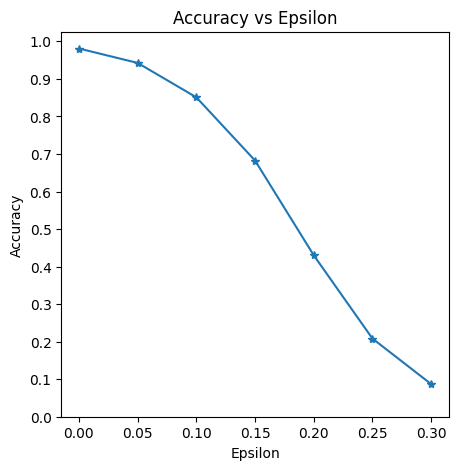

In [29]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## 敵対的サンプルの例

- 画像に追加されたノイズの存在にはより気付きやすくなる
- 正解率の低下と気付かれやすさの間にはトレードオフの関係があり、攻撃者はそのトレードオフを考慮する必要がある。
- ϵの値ごとに、誤分類させることに成功した敵対的なサンプルの例をいくつか示す

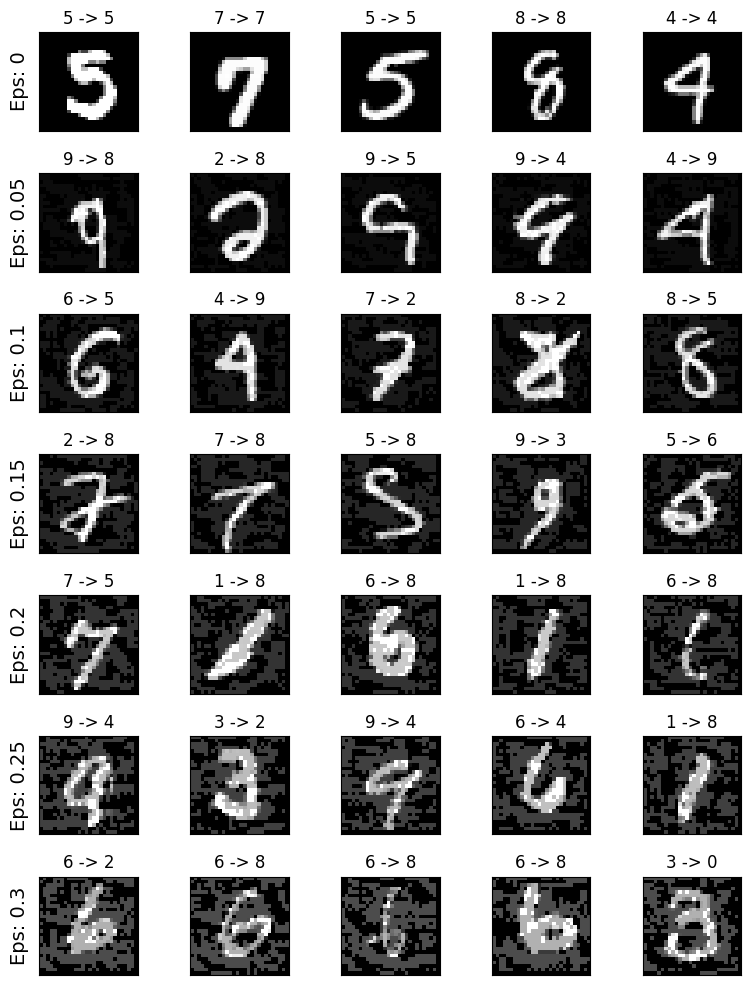

In [30]:
# 各epsilonでの敵対的なサンプルの例をプロットする
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# まとめ

- 本チュートリアルで扱った攻撃手法は、まさに敵対的攻撃研究の始まりとなった事例です。
- この研究以来、機械学習モデルに対して攻撃する方法や、逆に敵対者から機械学習モデルを防御する方法について、その後も多くのアイデアが生まれている
  - NIPS2017では敵対的攻撃と防御のコンペが行われた。
  - コンペで使用された手法の多くは[Adversarial Attacks and Defences Competition](https://arxiv.org/pdf/1804.00097.pdf)という論文で紹介されている。
  
- モデルを防御するための試みは、入力に自然にノイズが追加されるケースと、入力が悪意を持って細工されるケースの両方に対し、モデルのロバスト性を高めるため
  結果として一般的に、機械学習モデルをロバストにするアイデアへと繋がります。
  
- 敵対的研修は画像分野に限定されたものではない。画像とは異なるデータ形式における敵対的攻撃と防御がある
  - ex. [音声対テキストモデルに対する攻撃](https://arxiv.org/pdf/1801.01944.pdf)
  
- 敵対的な機械学習についてさらに理解を深めるための（おそらく）最良の方法は、実際に自分で自分のモデルを攻撃してみること
  - NIPS2017の大会で紹介されている、本チュートリアルとは異なる攻撃を実装してみて、FGSMとの違いを確認してみましょう。そして、自分の攻撃からモデルを防御してみてください。